In [ ]:
import pandas as pd
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage import data,exposure
from skimage.io import imshow,imread
from skimage.transform import resize
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense,Input,Conv2D,MaxPool2D,Flatten,Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import cv2

Data train

In [ ]:
data = pd.read_csv("sign_mnist_train.csv")
x_values = np.hstack([data.iloc[:20000, i].values.reshape(-1, 1)  for i in range(1,785)])
y_values = data.iloc[:20000, 0].values
X_train, X_test, y_train, y_test = train_test_split(x_values, y_values,train_size=0.8, stratify=y_values)
X_train = X_train/255
X_test = X_test/255
print(X_train)
print(y_train)
print(X_train.shape)
print(y_train.shape)

[[0.79607843 0.8        0.80784314 ... 0.89019608 0.88627451 0.87843137]
 [0.56470588 0.58431373 0.59607843 ... 0.76078431 0.75686275 0.75686275]
 [0.43137255 0.46666667 0.49019608 ... 0.74901961 0.74509804 0.74509804]
 ...
 [0.56862745 0.57647059 0.58431373 ... 0.73333333 0.73333333 0.73333333]
 [0.37254902 0.39215686 0.40784314 ... 0.58431373 0.58823529 0.58823529]
 [0.60392157 0.61568627 0.61960784 ... 0.69019608 0.70196078 0.70196078]]
[16 13  2 ... 18 21  2]
(16000, 784)
(16000,)


In [ ]:

values, counts = np.unique(y_values, return_counts=True)

for v, p in zip(values, counts / np.sum(counts)):
  print(f"{100*p:5.2f}% of all images have label {v}")

 4.39% of all images have label 0
 3.19% of all images have label 1
 4.76% of all images have label 2
 4.14% of all images have label 3
 3.64% of all images have label 4
 4.10% of all images have label 5
 4.18% of all images have label 6
 3.23% of all images have label 7
 4.22% of all images have label 8
 3.43% of all images have label 10
 5.05% of all images have label 11
 3.39% of all images have label 12
 3.68% of all images have label 13
 4.88% of all images have label 14
 4.47% of all images have label 15
 4.96% of all images have label 16
 4.43% of all images have label 17
 4.47% of all images have label 18
 4.63% of all images have label 19
 4.05% of all images have label 20
 4.30% of all images have label 21
 4.43% of all images have label 22
 4.30% of all images have label 23
 3.68% of all images have label 24


Data test

In [ ]:
data_test = pd.read_csv("sign_mnist_test.csv")
print(data_test)
x_test_real = np.hstack([data_test.iloc[:7000, i].values.reshape(-1, 1)  for i in range(1,785)])
print(x_test_real.shape)
y_test_real = data_test.iloc[:7000, 0].values
x_test_real = x_test_real/255
print(y_test_real)

      label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0         6     149     149     150     150     150     151     151     150   
1         5     126     128     131     132     133     134     135     135   
2        10      85      88      92      96     105     123     135     143   
3         0     203     205     207     206     207     209     210     209   
4         3     188     191     193     195     199     201     202     203   
...     ...     ...     ...     ...     ...     ...     ...     ...     ...   
7167      1     135     119     108     102     105      99      61     103   
7168     12     157     159     161     164     166     166     171     174   
7169      2     190     191     190     191     190     190     192     192   
7170      4     201     205     208     209     214     216     218     223   
7171      2     173     174     173     174     173     173     175     175   

      pixel9  ...  pixel775  pixel776  pixel777  pi

In [ ]:
values1, counts1 = np.unique(y_test_real, return_counts=True)
print(np.sum(counts1))
print(counts1)
print(values1)
sum = 0
for v, p in zip(values1, counts1 / np.sum(counts1)):
  sum += p
  print(f"{100*p:5.2f}% of all images have label {v}")

print(sum)

1379
[62 86 56 50 96 54 73 83 58 66 35 74 45 50 77 27 23 41 56 47 76 32 47 65]
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
 4.50% of all images have label 0
 6.24% of all images have label 1
 4.06% of all images have label 2
 3.63% of all images have label 3
 6.96% of all images have label 4
 3.92% of all images have label 5
 5.29% of all images have label 6
 6.02% of all images have label 7
 4.21% of all images have label 8
 4.79% of all images have label 10
 2.54% of all images have label 11
 5.37% of all images have label 12
 3.26% of all images have label 13
 3.63% of all images have label 14
 5.58% of all images have label 15
 1.96% of all images have label 16
 1.67% of all images have label 17
 2.97% of all images have label 18
 4.06% of all images have label 19
 3.41% of all images have label 20
 5.51% of all images have label 21
 2.32% of all images have label 22
 3.41% of all images have label 23
 4.71% of all images have label 24
0.99999999999999

SVM without using HOG

In [ ]:
pipe = Pipeline([("SVM",SVC(kernel="poly"))])
param_grid = {
    'SVM__C': [0.1, 1, 10],                  # Regularization parameter
    'SVM__degree': [2, 3, 4],                # Degree of the polynomial kernel function
}

grid_search = GridSearchCV(pipe,param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('SVM', SVC(kernel='poly'))]),
             param_grid={'SVM__C': [0.1, 1, 10], 'SVM__degree': [2, 3, 4]})

In [ ]:
print(grid_search.best_params_)

{'SVM__C': 1, 'SVM__degree': 2}


In [ ]:

print(grid_search.score(X_train, y_train))
print(grid_search.score(X_test, y_test))
print(grid_search.score(x_test_real, y_test_real))
y_pred = grid_search.predict(x_test_real)
print("Accuracy:",metrics.accuracy_score(y_test_real, y_pred))
print("F1 Score:",metrics.f1_score(y_test_real, y_pred, average='weighted'))
print("Precision: ",metrics.precision_score(y_test_real,y_pred, average='weighted'))
print("Recall: ",metrics.recall_score(y_test_real,y_pred,average = 'weighted'))


1.0
1.0
0.7932857142857143
Accuracy: 0.7932857142857143
F1 Score: 0.7946617321039006
Precision:  0.8082729608942307
Recall:  0.7932857142857143


histogram of oriented gradients

In [ ]:
def get_hog(image):

    fd,hog_image=hog(image.reshape(28, 28),orientations=9,pixels_per_cell=(2,2),
                        cells_per_block=(1, 1),visualize=True,feature_vector=True)
    return(fd,hog_image)

In [ ]:
def show_hog(image, hog_image):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)


    ax1.imshow(image, cmap=plt.cm.gray)
    ax1.set_title('Input image')

    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0,10))

    # Display the overlay
    ax2.imshow(hog_image_rescaled, cmap='gray')


    ax2.set_title('Histogram of Oriented Gradients')
    plt.show()

In [ ]:
def hof_equa(image):
    image = cv2.convertScaleAbs(image)
    equalized_image = cv2.equalizeHist(image)
    vector,hog_image = get_hog(equalized_image)
    return vector

In [ ]:
image = X_train[200].reshape(28, 28, 1).astype(np.float32)
image1 = hof_equa(X_train[1].reshape(28, 28,1))
print(image1.shape)
tmp = []

image = cv2.convertScaleAbs(image)
equalized_image = cv2.equalizeHist(image)
vector,hog_image = get_hog(equalized_image)
tmp.append(image1)
tmp.append(vector)
print(np.array(tmp).shape)
show_hog(equalized_image, hog_image)

(1764,)
(2, 1764)


NameError: name 'show_hog' is not defined

[0. 0. 0. ... 0. 0. 0.]


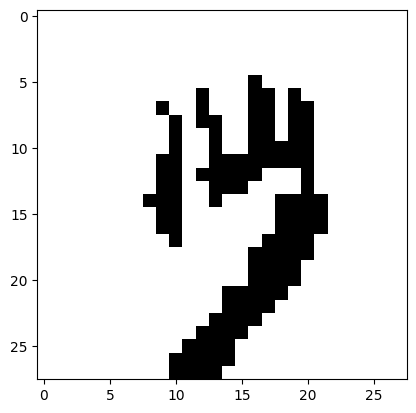

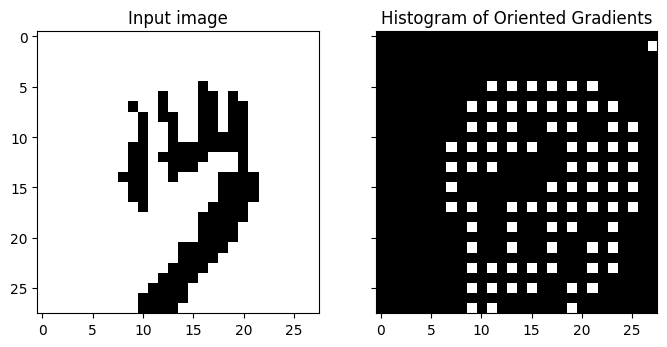

In [ ]:
image1 = X_train[1].reshape(28, 28)*255
ret, pic = cv2.threshold(image1,127 , 255, cv2.THRESH_BINARY)
plt.imshow(pic, cmap="gray")
vector1,hog_image1 = get_hog(equalized_image)
print(vector1)
show_hog(pic, hog_image1)

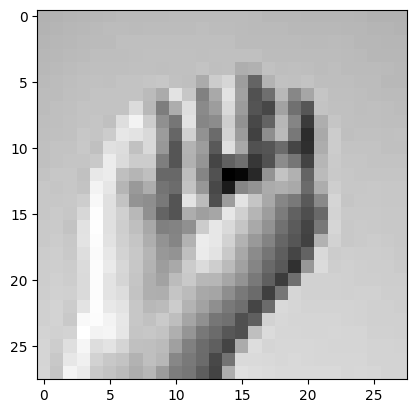

In [ ]:
plt.imshow(X_train[1].reshape(28, 28), cmap="gray")

Before HOG process
(100, 150, 3)
After HOG process
(6732,)


<ipython-input-10-032c81a5be5b>:8: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_panda = hog(resized_panda, orientations=9, pixels_per_cell=(8, 8),


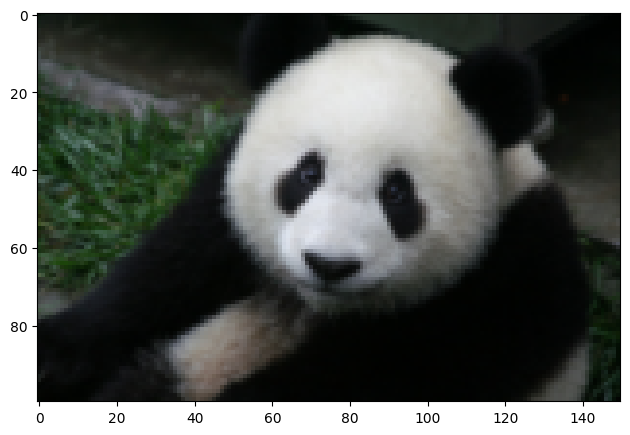

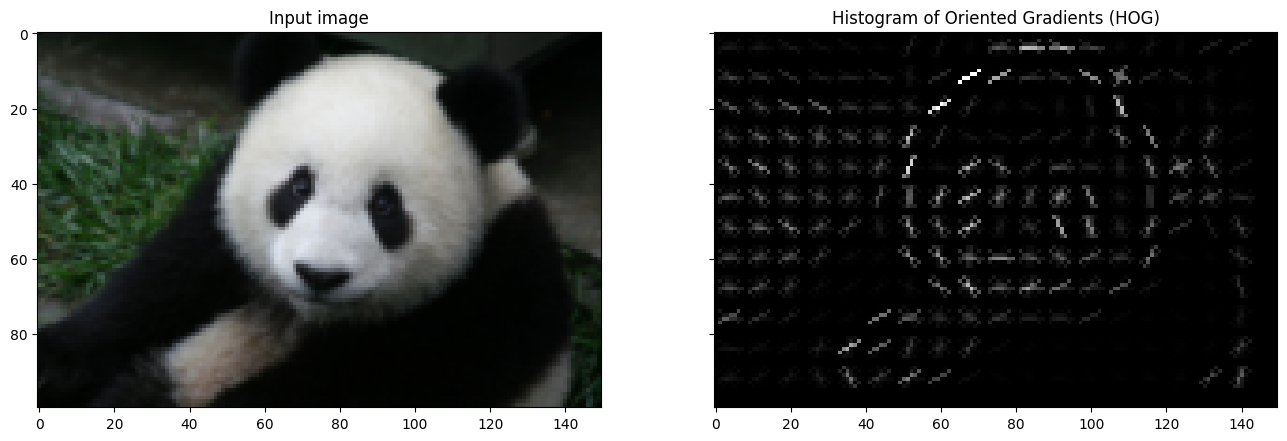

In [ ]:
panda = imread('panda.jpg')
imshow(panda)

resized_panda = resize(panda, (100,150))
print("Before HOG process")
imshow(resized_panda)
print(resized_panda.shape)
fd, hog_panda = hog(resized_panda, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True,feature_vector=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)

ax1.imshow(resized_panda, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_panda_rescaled = exposure.rescale_intensity(hog_panda, in_range=(0, 10))

ax2.imshow(hog_panda, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients (HOG)')

print("After HOG process")
print(fd.shape)

plt.show()

Transform the data set using HOG

In [ ]:
X_train_hog = []
X_test_hog = []
X_test_real_hog = []
for i in range(16000):
    X_train_hog.append(hof_equa(np.array(X_train[i]))[0])

for i in range(4000):
    X_test_hog.append(hof_equa(np.array(X_test[i]))[0])

for i in range(7000):
    X_test_real_hog.append(hof_equa(np.array(x_test_real[i]))[0])

X_train_hog = np.array(X_train_hog)
X_test_hog = np.array(X_test_hog)
X_test_real_hog = np.array(X_test_real_hog)

In [ ]:
print(X_train_hog.shape)
print(X_train_hog)
print(X_test_hog.shape)
print(X_test_real_hog.shape)

(16000,)
[0. 0. 0. ... 0. 0. 0.]
(4000,)
(7000,)


Using PCA to decrase the dimension

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train_hog)
X_test_pca = pca.transform(X_test_hog)
X_test_real_pca = pca.transform(X_test_real_hog)


In [ ]:
print(X_train_pca.shape)
print(X_test_pca.shape)
print(X_test_real_pca.shape)

(16000, 30)
(4000, 30)
(7000, 30)


SVM using HOG

In [ ]:
model = SVC(kernel="poly", C=1, degree=2)
model.fit(X_train_hog.reshape(-1, 1), y_train)
print(model.score(X_train_hog.reshape(-1, 1), y_train))
print(model.score(X_test_hog.reshape(-1, 1), y_test))
y_pred = model.predict(X_test_real_hog.reshape(-1, 1))
print("Accuracy:",metrics.accuracy_score(y_test_real, y_pred))
print("F1 Score:",metrics.f1_score(y_test_real, y_pred, average='weighted'))
print("Precision: ",metrics.precision_score(y_test_real,y_pred, average='weighted'))
print("Recall: ",metrics.recall_score(y_test_real,y_pred,average = 'weighted'))


0.0488125
0.04875
Accuracy: 0.02057142857142857
F1 Score: 0.0013466016834877375
Precision:  0.0009028026783027802
Recall:  0.02057142857142857


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM using HOG and euqalized

In [ ]:
model = SVC(kernel="poly", C=1, degree=2)
model.fit(X_train_hog, y_train)
print(model.score(X_train_hog, y_train))
print(model.score(X_test_hog, y_test))
y_pred = model.predict(X_test_real_hog)
print("Accuracy:",metrics.accuracy_score(y_test_real, y_pred))
print("F1 Score:",metrics.f1_score(y_test_real, y_pred, average='weighted'))
print("Precision: ",metrics.precision_score(y_test_real,y_pred, average='weighted'))
print("Recall: ",metrics.recall_score(y_test_real,y_pred,average = 'weighted'))

SVM using HOG and PCA

In [ ]:
model_pca = SVC(kernel="poly", C=1, degree=2)
model_pca.fit(X_train_pca, y_train)
print(model_pca.score(X_train_pca, y_train))
print(model_pca.score(X_test_pca, y_test))
y_pred = model_pca.predict(X_test_real_pca)
print("Accuracy:",metrics.accuracy_score(y_test_real, y_pred))
print("F1 Score:",metrics.f1_score(y_test_real, y_pred, average='weighted'))
print("Precision: ",metrics.precision_score(y_test_real,y_pred, average='weighted'))
print("Recall: ",metrics.recall_score(y_test_real,y_pred,average = 'weighted'))

0.9996875
1.0
Accuracy: 0.8852857142857142
F1 Score: 0.8882489421398347
Precision:  0.8990997992611653
Recall:  0.8852857142857142


KNN (the optimal n_neighboor using gridsearch is 2) Before using HOG

In [ ]:
knn_model1 = KNeighborsClassifier(n_neighbors=2)
knn_model1.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=2)

In [ ]:
print(knn_model1.score(X_train, y_train))
print(knn_model1.score(X_test, y_test))
y_pred = knn_model1.predict(x_test_real)
print("Accuracy:",metrics.accuracy_score(y_test_real, y_pred))
print("F1 Score:",metrics.f1_score(y_test_real, y_pred, average='weighted'))
print("Precision: ",metrics.precision_score(y_test_real,y_pred, average='weighted'))
print("Recall: ",metrics.recall_score(y_test_real,y_pred,average = 'weighted'))

0.998625
0.99375
Accuracy: 0.7875714285714286
F1 Score: 0.7865830370883364
Precision:  0.8123350944388669
Recall:  0.7875714285714286


After using HOG

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train_hog, y_train)


KNeighborsClassifier(n_neighbors=2)

In [ ]:
print(knn_model.score(X_train_hog, y_train))
print(knn_model.score(X_test_hog, y_test))
y_pred = knn_model.predict(X_test_real_hog)
print(y_pred)
print("Accuracy:",metrics.accuracy_score(y_test_real, y_pred))
print("F1 Score:",metrics.f1_score(y_test_real, y_pred, average='weighted'))
print("Precision: ",metrics.precision_score(y_test_real,y_pred, average='weighted'))
print("Recall: ",metrics.recall_score(y_test_real,y_pred,average = 'weighted'))

1.0
1.0
[ 6  5 10 ... 11  4  2]
Accuracy: 0.8742857142857143
F1 Score: 0.8754029322349213
Precision:  0.8932431270813919
Recall:  0.8742857142857143


After using HOG and PCA

In [ ]:
knn_model_pca = KNeighborsClassifier(n_neighbors=2)
knn_model_pca.fit(X_train_pca, y_train)

KNeighborsClassifier(n_neighbors=2)

In [ ]:
print(knn_model_pca.score(X_train_pca, y_train))
print(knn_model_pca.score(X_test_pca, y_test))
y_pred = knn_model_pca.predict(X_test_real_pca)
print(y_pred)
print("Accuracy:",metrics.accuracy_score(y_test_real, y_pred))
print("F1 Score:",metrics.f1_score(y_test_real, y_pred, average='weighted'))
print("Precision: ",metrics.precision_score(y_test_real,y_pred, average='weighted'))
print("Recall: ",metrics.recall_score(y_test_real,y_pred,average = 'weighted'))

1.0
1.0
[ 6  5 10 ... 11  4  2]
Accuracy: 0.9
F1 Score: 0.8996647192510058
Precision:  0.9059673921103887
Recall:  0.9


DCT

In [ ]:
from scipy.fftpack import dct
from scipy.fftpack import idct
import numpy as np

def dct2(f):
    """2D Discrete Cosine Transform

    Args:
        f: Square array

    Returns:
        2D DCT of f
    """
    return dct(dct(f, axis=0, norm='ortho' ),axis=1, norm='ortho')




def idct2(f):
    """2D Inverse Discrete Cosine Transform

    Args:
        f: Square array

    Returns:
        2D Inverse DCT of f
    """
    return idct(idct(f, axis=0 , norm='ortho'), axis=1 , norm='ortho')


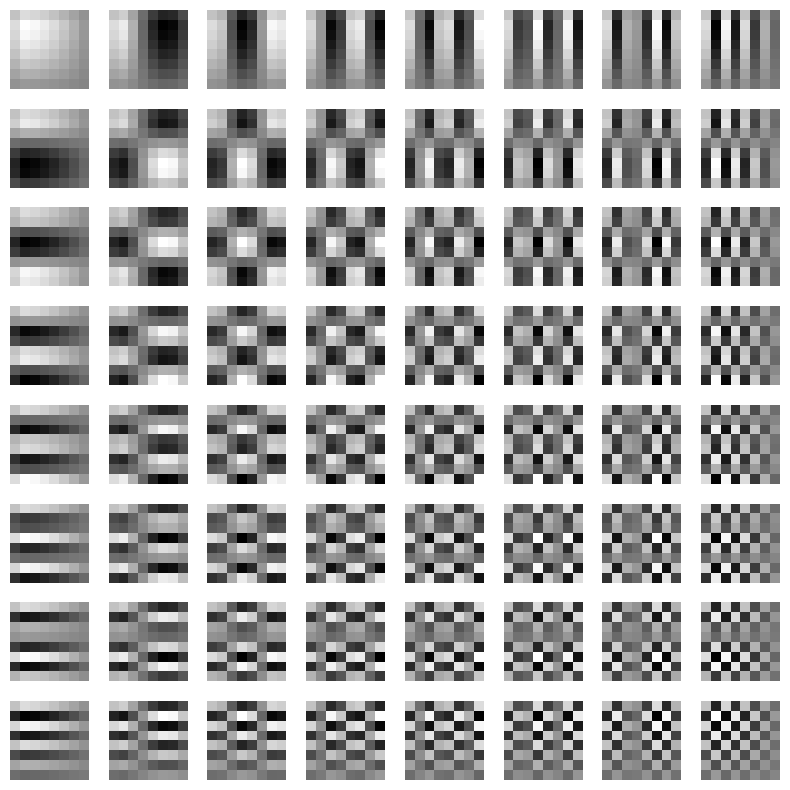

In [ ]:
import graphlearning as gl

dct_basis = np.zeros((64,64))
k = 0
for i in range(8):
    for j in range(8):
        g = np.zeros((8,8))
        g[i,j]=1
        dct_basis[k,:] = dct2(g).flatten()
        k+=1

dct_basis = dct_basis/np.max(np.absolute(dct_basis))
gl.utils.image_grid(dct_basis,n_rows=8,n_cols=8)

In [ ]:
!pip install graphlearning


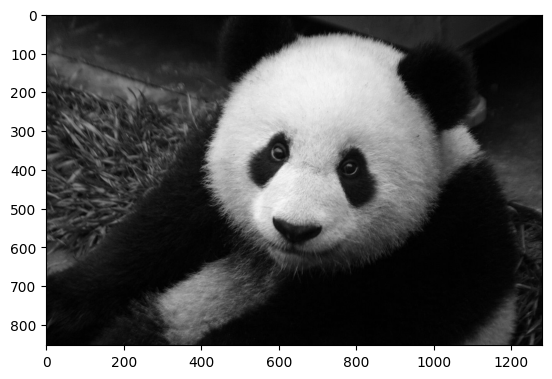

In [ ]:
#Load image
I = plt.imread("panda.jpg")
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
plt.imshow(I,cmap='gray')

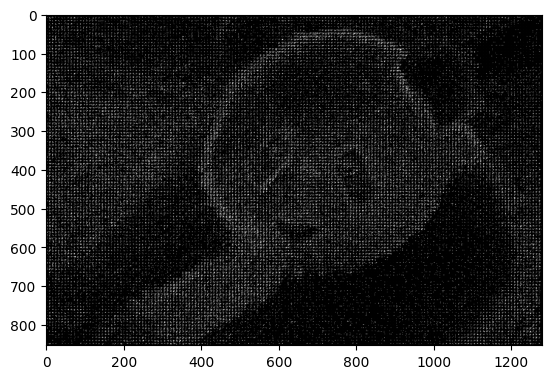

In [ ]:
patch_size = 8  #8x8 patch
I_dct = np.zeros_like(I)
for i in range(0,I.shape[0],patch_size):
    for j in range(0,I.shape[1],patch_size):
        I_dct[i:(i+patch_size),j:(j+patch_size)] = dct2(I[i:(i+patch_size),j:(j+patch_size)])

plt.imshow(I_dct,cmap='gray')

In [ ]:
def transform_DCT(I):
    patch_size = 8  #8x8 patch
    I_comp = np.zeros_like(I)
    for i in range(0,I.shape[0],patch_size):
        for j in range(0,I.shape[1],patch_size):
            I_comp[i:(i+patch_size),j:(j+patch_size)] = idct2(I[i:(i+patch_size),j:(j+patch_size)])
    return I_comp

transform data set using DCT

In [ ]:
DCT_X_train = []
DCT_X_test_real = []
for i in range(16000):
     image_DCT = transform_DCT(X_train[i].reshape(28, 28))
     thresh = 0.1
     I_thresh = image_DCT * (np.absolute(image_DCT) > thresh*np.max(np.absolute(image_DCT)))
     DCT_X_train.append(I_thresh)
for i in range(7000):
     image_DCT = transform_DCT(x_test_real[i].reshape(28, 28))
     thresh = 0.01
     I_thresh = image_DCT * (np.absolute(image_DCT) > thresh*np.max(np.absolute(image_DCT)))
     DCT_X_test_real.append(I_thresh)
DCT_X_train = np.array(DCT_X_train)
DCT_X_test_real = np.array(DCT_X_test_real)

In [ ]:
DCT_X_train = DCT_X_train.reshape(-1, 784)
DCT_X_test_real  = DCT_X_test_real.reshape(-1, 784)
print(DCT_X_train.shape)
print(DCT_X_test_real.shape)

(16000, 784)
(7000, 784)


SVM with DCT

In [ ]:
model_SVC = SVC(kernel="linear")
param_grid = {
              'C': [0.1, 1, 10, 100]}

print(y_train.shape)
grid_search_SVM = GridSearchCV(model_SVC, param_grid, cv=5)

grid_search_SVM.fit(DCT_X_train, y_train)

(16000,)


GridSearchCV(cv=5, estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 1, 10, 100]})

In [ ]:
print(grid_search_SVM.best_params_)
print(grid_search_SVM.score(DCT_X_train, y_train))
print(grid_search_SVM.score(DCT_X_test_real, y_test_real))

{'C': 10}
1.0
0.623


In [ ]:
model_SVM = SVC(kernel="poly", C=0.1)
model_SVM.fit(DCT_X_train, y_train)


SVC(C=0.1, kernel='poly')

In [ ]:
print(model_SVM.score(DCT_X_train, y_train))
print(model_SVM.score(DCT_X_test_real, y_test_real))

0.57325
0.43814285714285717


CNN

In [ ]:
X_train = X_train.reshape(16000, 28, 28, 1)
X_test = X_test.reshape(4000, 28, 28, 1)
x_test_real = x_test_real.reshape(7000, 28, 28, 1)

Data agumentation to avoid overfiiting . It basically generates new picture (feature) . It take the data set and randomly rotate the picture or shift the picture ,..

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
)
datagen.fit(X_train)

transform the y_data to the category type.

In [ ]:
y_train_ca = to_categorical(y_train,25)
y_test_ca = to_categorical(y_test,25)

print(y_train_ca.shape)
print(y_test_ca.shape)


(16000, 25)
(4000, 25)


adjust the learning rate while training the model. This improve convergence becasue if after 2 epcohs the accuracy doesnot change much, it reduces the learning rate by 0.5 and the minimum value for learning rate is 0.00001

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
model = Sequential()

model.add(Conv2D(filters=75,kernel_size=(4, 4), input_shape=(28, 28, 1), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(75 , (3,3) , strides = 1 , activation = 'relu'))
# each node has 10% probability that will drop out . In other word, it will be set to zero . It will prevent overfiting
model.add(Dropout(0.1))
model.add(MaxPool2D((2,2) , strides = 2 ))
model.add(Flatten())

model.add(Dense(128, activation="relu"))
# each node has 10% probability that will drop out . In other word, it will be set to zero . It will prevent overfiting
model.add(Dropout(0.1))
model.add(Dense(25, activation="softmax"))

model.compile(optimizer="adam",
               loss='categorical_crossentropy',
               metrics=['accuracy'])

history = model.fit(datagen.flow(X_train,y_train_ca, batch_size = 32) ,epochs = 20 , validation_data = (X_test, y_test_ca))

print(history)
print(model.summary())

Epoch 1/20
500/500 [==============================] - 43s 80ms/step - loss: 1.9893 - accuracy: 0.3896 - val_loss: 0.5615 - val_accuracy: 0.8447
Epoch 2/20
500/500 [==============================] - 40s 80ms/step - loss: 0.8162 - accuracy: 0.7296 - val_loss: 0.2559 - val_accuracy: 0.9423
Epoch 3/20
500/500 [==============================] - 41s 81ms/step - loss: 0.5170 - accuracy: 0.8284 - val_loss: 0.1404 - val_accuracy: 0.9735
Epoch 4/20
500/500 [==============================] - 39s 77ms/step - loss: 0.3801 - accuracy: 0.8729 - val_loss: 0.0921 - val_accuracy: 0.9850
Epoch 5/20
500/500 [==============================] - 41s 81ms/step - loss: 0.2926 - accuracy: 0.9026 - val_loss: 0.0786 - val_accuracy: 0.9818
Epoch 6/20
500/500 [==============================] - 40s 81ms/step - loss: 0.2457 - accuracy: 0.9189 - val_loss: 0.0296 - val_accuracy: 0.9977
Epoch 7/20
500/500 [==============================] - 38s 77ms/step - loss: 0.1966 - accuracy: 0.9356 - val_loss: 0.0331 - val_accuracy:

In [ ]:
from sklearn.metrics import classification_report

print(model.evaluate(X_test, y_test_ca))
predicionts = model.predict(x_test_real)
y_pred = np.argmax(predicionts, axis=1)

print(type(y_pred[0]))
print(classification_report(y_test_real, y_pred))

125/125 [==============================] - 3s 24ms/step - loss: 0.0064 - accuracy: 0.9990
[0.006414436735212803, 0.9990000128746033]
219/219 [==============================] - 5s 21ms/step
<class 'numpy.int64'>
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       321
           1       1.00      0.98      0.99       426
           2       1.00      1.00      1.00       302
           3       1.00      1.00      1.00       233
           4       1.00      1.00      1.00       484
           5       1.00      1.00      1.00       244
           6       1.00      0.95      0.97       337
           7       1.00      1.00      1.00       424
           8       0.98      1.00      0.99       281
          10       1.00      1.00      1.00       322
          11       1.00      1.00      1.00       203
          12       0.94      1.00      0.97       384
          13       1.00      1.00      1.00       285
          14       1.00      1.0

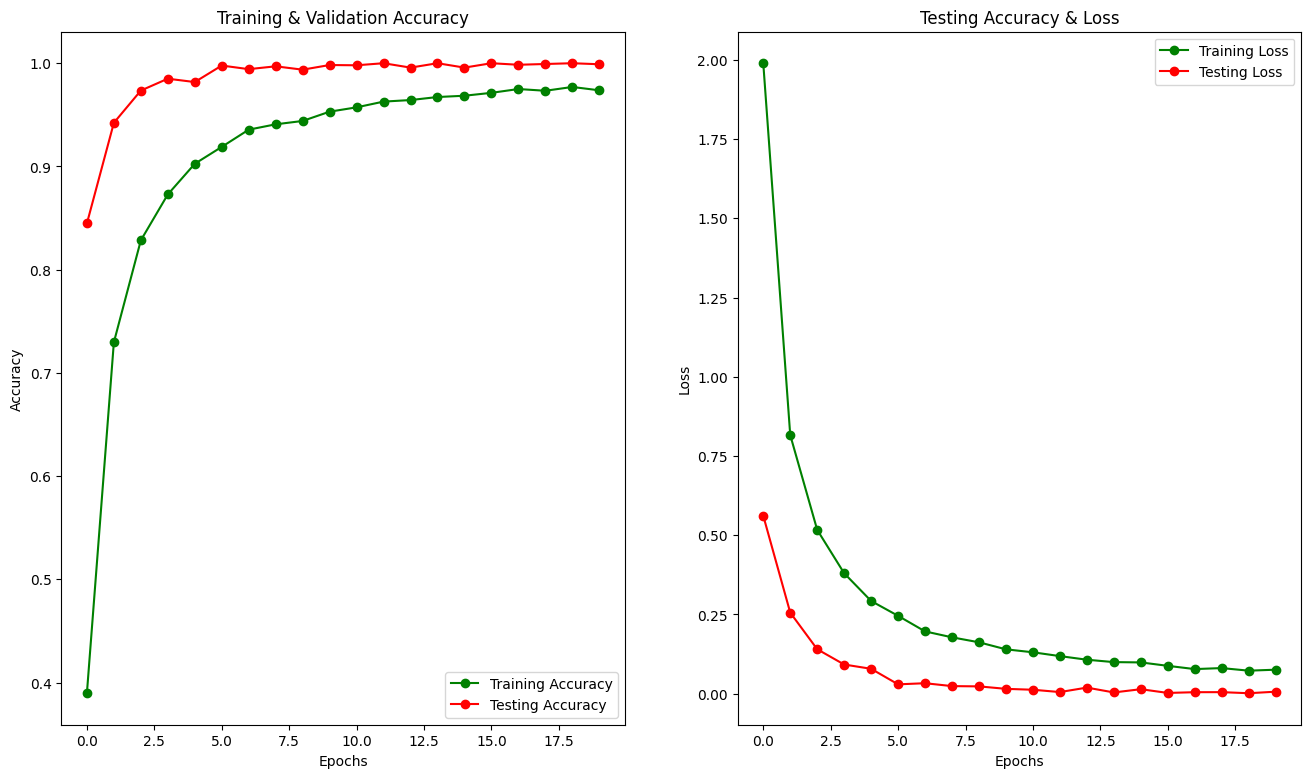

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
map_output = {
    0:"A",
    1:"B",
    2:"C",
    3:"D",
    4:"E",
    5:"F",
    6:"G",
    7:"H",
    8:"I",
    9:"None",
    10:"K",
    11:"L",
    12:"M",
    13:"N",
    14:"O",
    15:"P",
    16:"Q",
    17:"R",
    18:"S",
    19:"T",
    20:"U",
    21:"V",
    22:"W",
    23:"X",
    24:"Y",
    25:"None",
}

<ipython-input-57-6e83f02db5da>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,j)


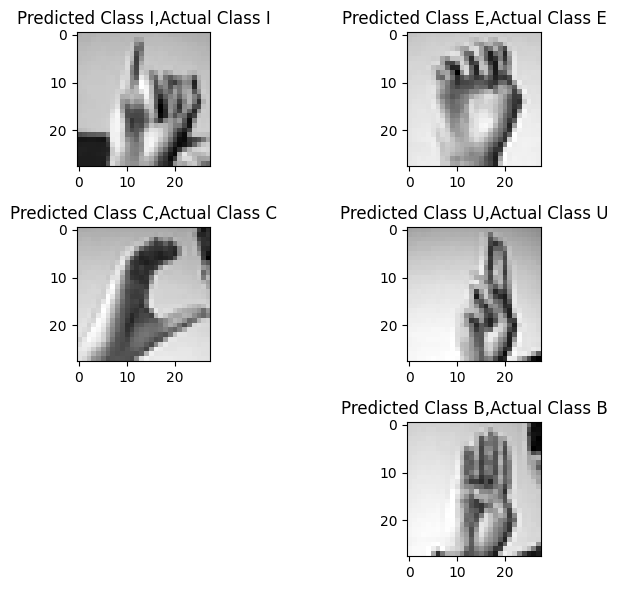

In [ ]:
i = 100
j = 1
plt.figure(figsize=(8, 6))
for prediction in y_pred[100:100+6]:
    plt.subplot(3,2,j)
    plt.imshow(x_test_real[i].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(map_output[prediction.item()], map_output[y_test_real[i]]))
    plt.tight_layout()
    i += 1
    j += 1
plt.show()